# Explore Zenodo community

In [1]:
from zenodoExplorer.zenexp import ze

recIDs = [10835267, 10712131]
with open("api.key", "r") as keyFile:
    ACCESS_TOKEN = keyFile.readline().rstrip()

ze = ze(ACCESS_TOKEN, recIDs)
ze.read_zdb()
ze.zdb.to_pd('AtomicConfigs')

,desc
tag,
ac1@10835267,"EC:EMC liquid PBC, isolated mols, volume scans..."
ac1@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 25% of all ..."
ac2@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 7% of all n..."


In [2]:
ze.zdb.to_pd('TrainData')

,at_conf,ab_init_code,ab_init_theo
tag,,,
td1@10835267,ac1@10835267,CASTEP,PBE-D2
td2@10835267,ac1@10835267,CP2K,PBE-D3
td1@10712131,ac1@10835267,VASP,B97-D3BJ
td2@10712131,ac1@10712131,PSI4,B97-D3BJ
td3@10712131,ac1@10712131,PSI4,wB97X-D3BJ
td4@10712131,ac2@10712131,PSI4,wB97X-D3BJ


In [3]:
ze.zdb.to_pd('MLIPs')

,tr_data,ml_code,ml_settings,fit_prop
tag,,,,
ml1@10835267,td1@10835267,GAP,"DS, Rcut 3/6","energy, forces, virial"
ml2@10835267,td1@10835267,GAP,"DTS, Rcut 3/6","energy, forces, virial"
ml3@10835267,td2@10835267,GAP,"DS, Rcut 3/6","energy, forces, virial"
ml4@10835267,td2@10835267,GAP,"DTS, Rcut 3/6","energy, forces, virial"
ml1@10712131,td1@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml2@10712131,td2@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml3@10712131,td3@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml4@10712131,td4@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"


In [4]:
ze.zdb.to_pd('MDSims')

,pes_model,md_code,md_system,md_no_at,md_ensmb,md_step,md_len,md_temp,md_pres
tag,,,,,,,,,
md1@10835267,ml4@10835267,LAMMPS,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,300 K,1 atm
md2@10835267,ml4@10835267,LAMMPS,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,350 K,1 atm
md1@10712131,ml3@10712131,ASE,EMC,1000,NPT,1.0 fs,1.0 ns,298 K,1 atm
md2@10712131,ml3@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,0.5 fs,0.5-1.0 ns,"298, 298, 298, 313 K",1 atm
md3@10712131,ml4@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.5 ns,"298, 298, 298, 313 K",1 atm
md4@10712131,ml1@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm
md5@10712131,ml2@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm


In [5]:
ze.zdb.plot()

# Get MD trajectories

In [6]:
import os
from aseMolec import pltProps as pp

def get_all_thermo(tag):
    thermo = {}
    flist = ze.read_dat_files(tag, ext='.thermo')
    for f in flist:
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

tags = ['md1@10835267', 'md2@10712131', 'md4@10712131', 'md5@10712131']
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(tag)

# from old paper, will be replaced with MACE MD
pp.rename_key(thermo['md1@10835267'], 'TimeStep', 'Time')
pp.rename_key(thermo['md1@10835267'], 'v_mdensity', 'Density')
pp.rename_key(thermo['md1@10835267'], 'c_compMSD[4]', 'MSD')
pp.convert_units(thermo['md1@10835267'], 'Density', 'g/cm$^3$', 1.0)
pp.convert_units(thermo['md1@10835267'], 'MSD', 'A$^2$', 1.0)
thermo['md1@10835267'] = {
    k_new : thermo['md1@10835267'][k_old]
    for k_old, k_new in zip(['67EMC_300K', '25EC_50EMC_300K', '57EC_29EMC_300K', '100EC_300K'],
                            ['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
}

for tag in thermo:
    pp.convert_units(thermo[tag], 'Time', 'ps', 0.001)

def_cols = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
def_lege = ['EMC', 'EC:EMC (3:7)', 'EC:EMC (7:3)', 'EC']
def_meth = ['GAP_IBM23_PBE', 'MACE_SD22NQ_wB97X', 'MACE_IBM23_B97', 'MACE_SD22NQ_B97']

# Compare MD trajectories

## compute average densities and diffusivities

In [102]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from aseMolec import pltProps as pp
import ase.units
densfact = (ase.units.m/1.0e2)**3/ase.units.mol

def compute(thermo_md, t0=0):
    # t0: in picoseconds, how much of the MD traj to ignore from the start
    idx = np.where(thermo_md['Time']['data']>t0)[0][0]
    t = thermo_md['Time']['data'][idx:]
    dens = thermo_md['Density']['data'][idx:]
    msd = thermo_md['MSD']['data'][idx:]

    dens_avg = dens.mean() #g/cm^3
    D, offs = np.polyfit(t, msd, deg=1)
    D /= 6 #A^2/ps
    D *= 100 #10^-10 m^2/s or 10^-6 cm^2/s
    return dens_avg, D, offs

dens_col = []
diff_col = []
offs_col = []
for tag in tags:
    dens = dict()
    diff = dict()
    offs = dict()
    for k in thermo[tag]:
        rho, D, o = compute(thermo[tag][k], t0=300)
        dens[k] = rho
        diff[k] = D
        offs[k] = o
    dens_col.append(dens)
    diff_col.append(diff)
    offs_col.append(offs)

dens_df = pd.DataFrame(dens_col).round(2)
dens_df.index = def_meth
dens_df.columns = def_lege

diff_df = pd.DataFrame(diff_col).round(2)
diff_df.index = def_meth
diff_df.columns = def_lege

## plot densities and diffusivities

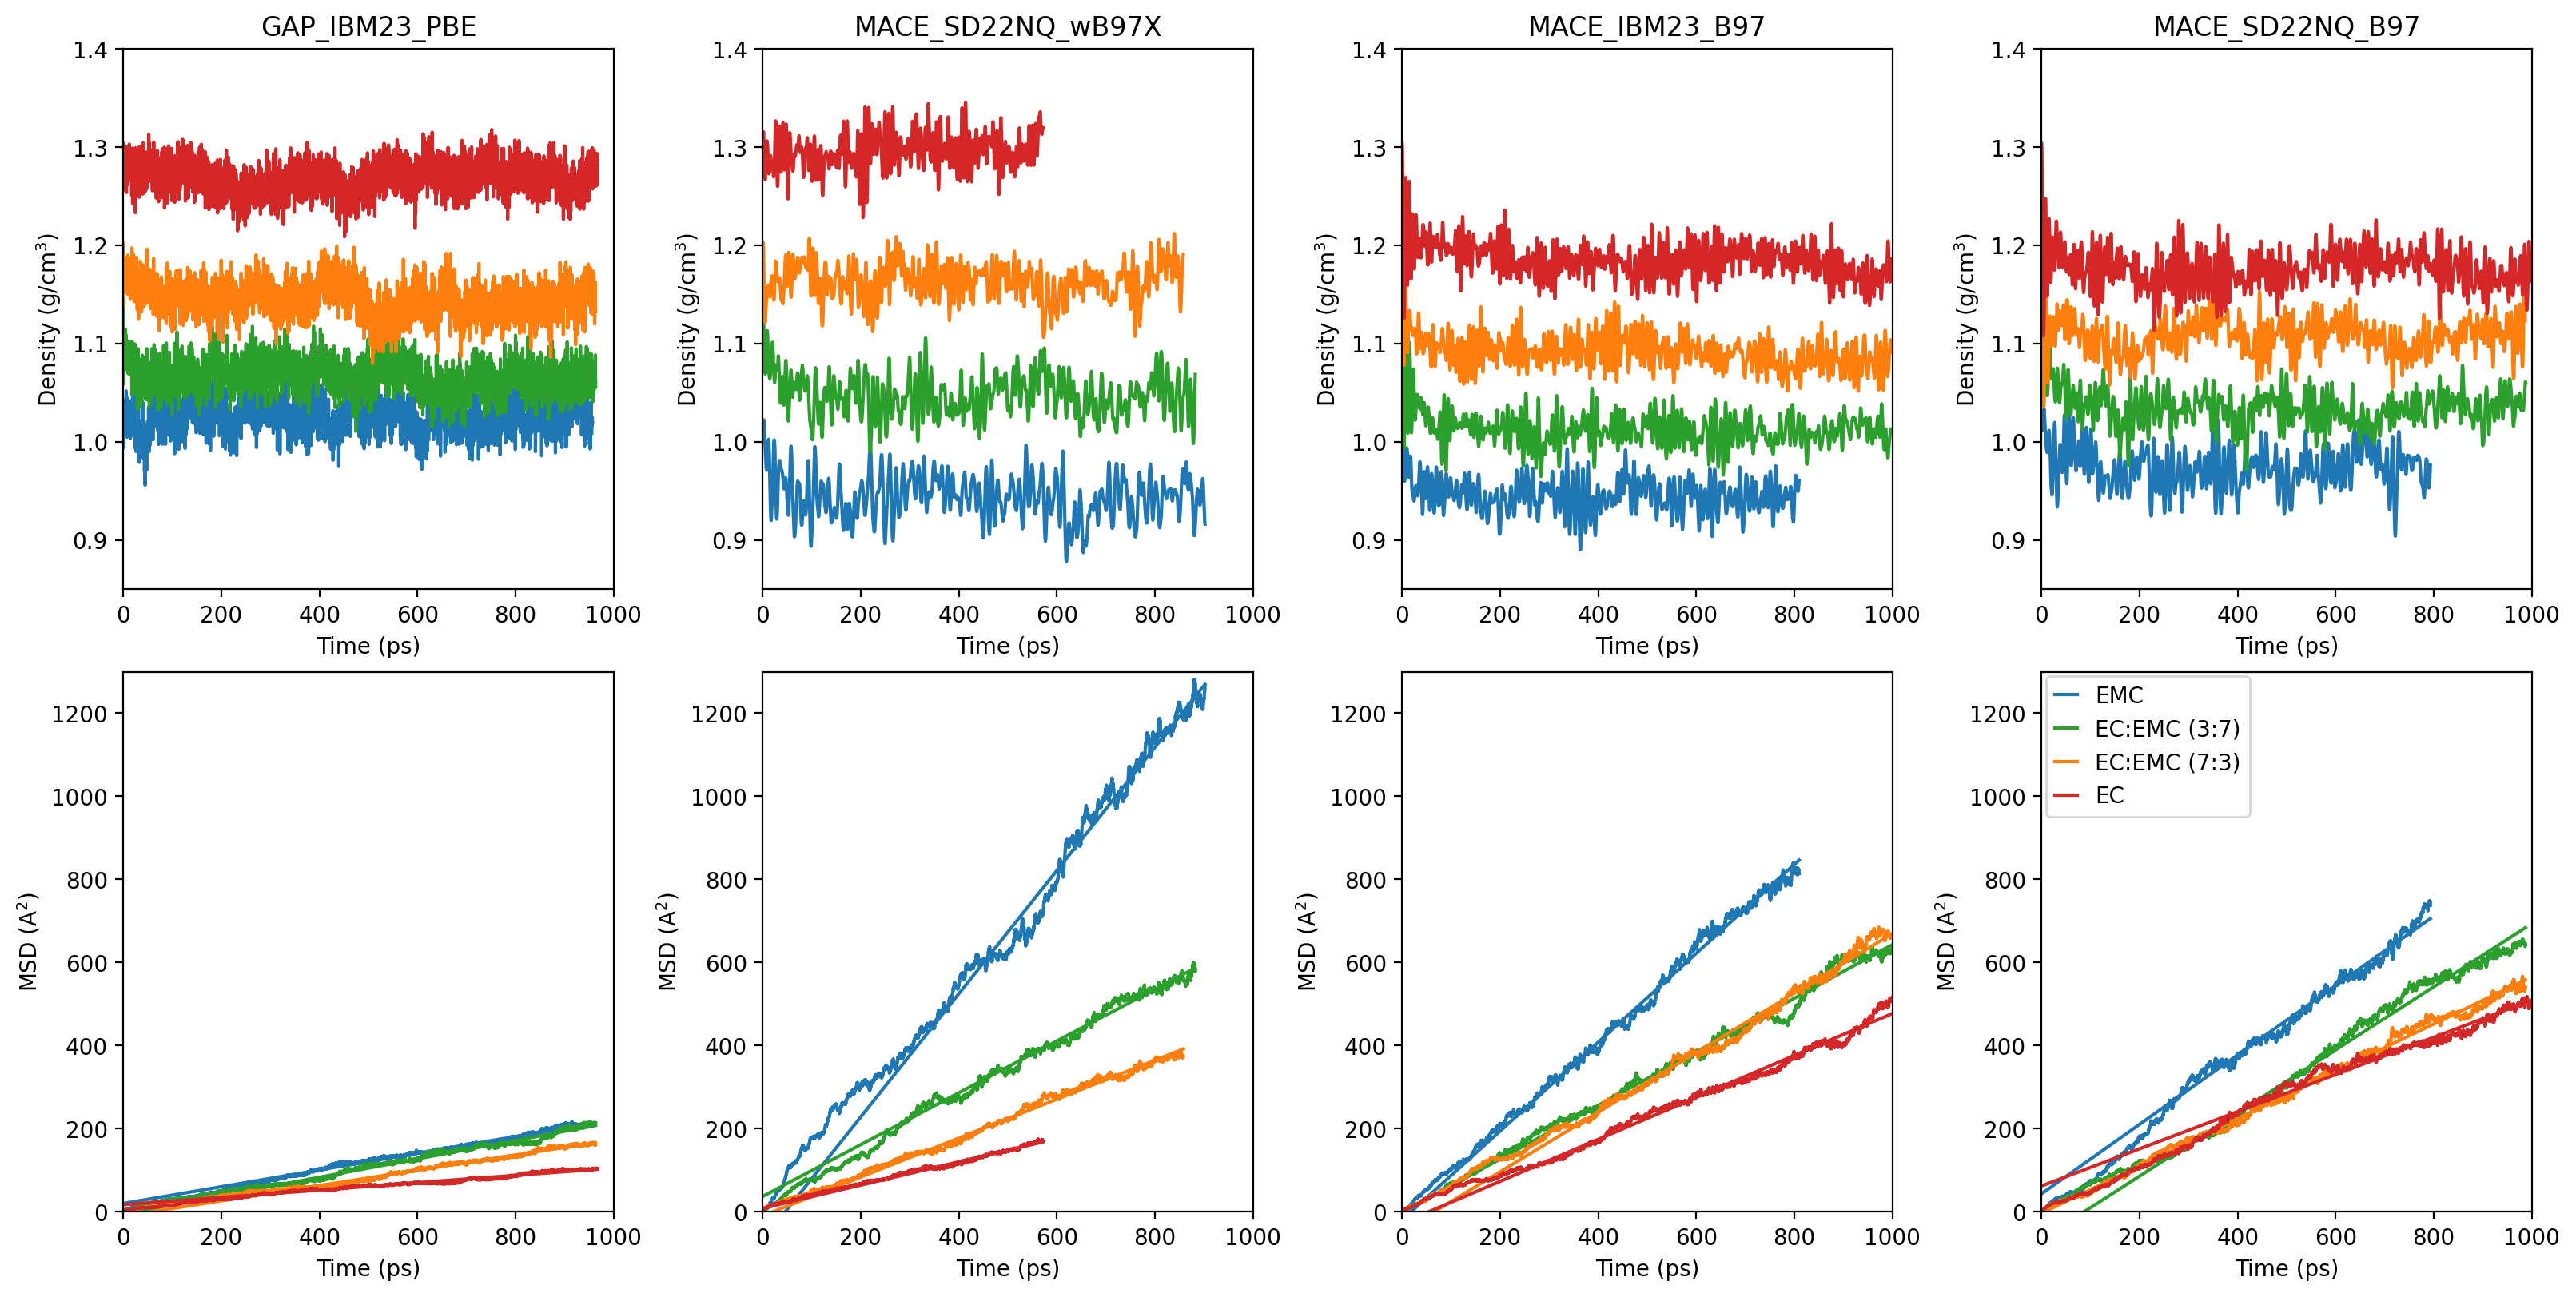

In [103]:
fig, axes = plt.subplot_mosaic(mosaic='ABCD;EFGH', figsize=(16,8), dpi=200, layout='constrained')

# Density
for tag, panel, title in zip(tags, ['A', 'B', 'C', 'D'], def_meth): #loop over methods
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]): #loop over compositions
        pp.simpleplot(thermo[tag][k], 'Time', 'Density', byKey=True, color=def_cols[i])
    plt.xlim([0,1000])
    plt.ylim([0.85,1.4])
    plt.title(title)

# Diffusivity
for j, (tag, panel) in enumerate(zip(tags, ['E', 'F', 'G', 'H'])): #loop over methods
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]): #loop over compositions
        pp.simpleplot(thermo[tag][k], 'Time', 'MSD', byKey=True, color=def_cols[i])
        plt.plot(thermo[tag][k]['Time']['data'], thermo[tag][k]['Time']['data']*diff_col[j][k]/100*6+offs_col[j][k], color=def_cols[i], label='_nolegend_')
    plt.xlim([0,1000])
    plt.ylim([0,1300])

plt.legend(def_lege, handlelength=1, loc='upper left', borderaxespad=0.2)


In [104]:
diff_df

,EMC,EC:EMC (3:7),EC:EMC (7:3),EC
GAP_IBM23_PBE,3.36,3.69,3.06,1.47
MACE_SD22NQ_wB97X,24.72,10.39,7.80,4.66
MACE_IBM23_B97,17.82,10.75,11.94,8.41
MACE_SD22NQ_B97,13.92,12.66,9.49,7.45


In [105]:
dens_df

,EMC,EC:EMC (3:7),EC:EMC (7:3),EC
GAP_IBM23_PBE,1.02,1.07,1.14,1.27
MACE_SD22NQ_wB97X,0.94,1.05,1.16,1.30
MACE_IBM23_B97,0.94,1.01,1.09,1.18
MACE_SD22NQ_B97,0.97,1.03,1.11,1.18


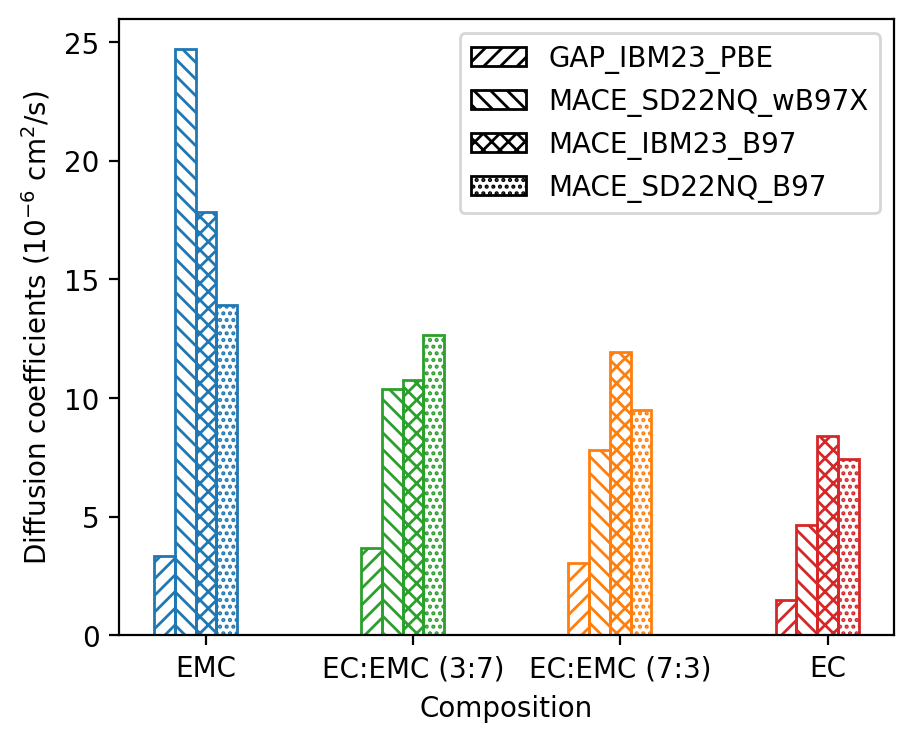

In [106]:
plt.figure(figsize=(5,4), dpi=200)

# def plot_stats(col, w=0.1):
col = diff_col
w = 0.1
N = int(len(col)/2)
def_htc = ['////','\\\\\\\\','xxxx','.....']
for i, (dat, htc) in enumerate(zip(col, def_htc)):
    plt.bar(np.arange(4)+(i-N)*w, [dat[k] for k in dat], width=w, edgecolor=def_cols, hatch=htc, fill=False)

plt.xticks(np.arange(4), def_lege)
plt.xlabel('Composition')
# plt.ylabel(r'Density (g/cm$^3$)')
plt.legend(def_meth, loc='upper right')

# plt.tight_layout()

plt.ylabel(r'Diffusion coefficients (10$^{-6}$ cm$^2$/s)')
# plt.legend(['Gen016/DTS', 'OPLS', 'Schrödinger', 'Gen016/DTS (wB97X-D3BJ)', 'NMR Experiment'], loc='upper left')
# plt.tight_layout()
# plt.savefig('new_figs/Comparison_Diffusion_300K_3.png')
# plt.close()

leg = plt.gca().get_legend()
for h in leg.legend_handles:
    h._hatch_color = (0,0,0,1)
    h._edgecolor = (0,0,0,1)

Text(0, 0.5, 'Diffusion coefficients (10$^{-6}$ cm$^2$/s)')

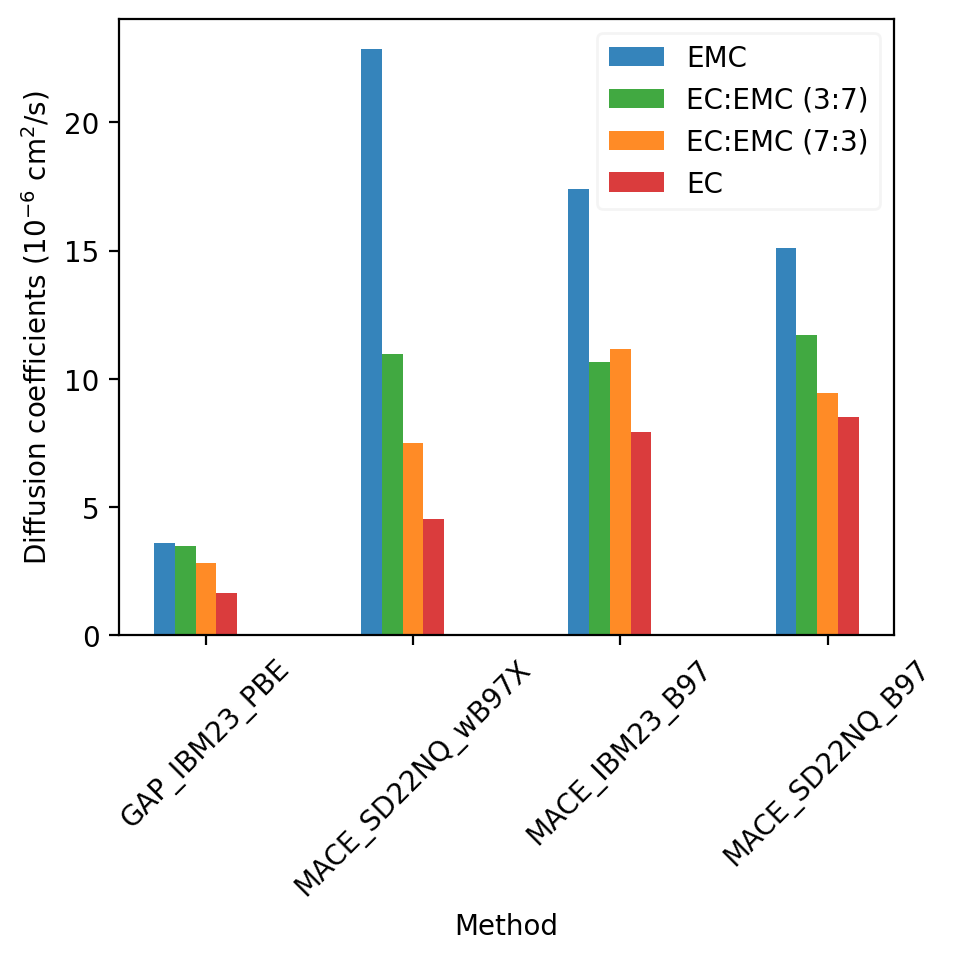

In [73]:
plt.figure(figsize=(5,4), dpi=200)

# def plot_stats(col, w=0.1):
col = diff_col
w = 0.1
N = int(len(col)/2)
for i, dat in enumerate(col):
    for j, (k, loc) in enumerate(zip(dat, np.arange(-N,N)*w)):
        plt.bar(loc+i, dat[k], width=w, color=def_cols[j], alpha=0.9)
        if i==0:    
            plt.legend(def_lege, loc='upper right', framealpha=0.2)

plt.xticks(np.arange(len(col)), def_meth, rotation=45)
plt.xlabel('Method')
plt.ylabel(r'Density (g/cm$^3$)')

plt.ylabel(r'Diffusion coefficients (10$^{-6}$ cm$^2$/s)')



# To Do List

- train MACE on td2@10835267
- run MD/300K all compositions with new model